In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import normaltest
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from helper_funcs_pageview import *
import random
import itertools
import io
dpi = 200

In [2]:
# param to determine whether to update figures or not
save_fig = False
# read data and print the head
data = pd.read_csv("../AB/page_visits_assignment.csv")
print(data.head(5))
print(data.tail(5))
data.shape

         Date  Visits  Easter  Christmas  Black Friday
0  01-01-2016     311       0          0             0
1  01-02-2016     564       0          0             0
2  01-03-2016     517       0          0             0
3  01-04-2016     652       0          0             0
4  01-05-2016     756       0          0             0
            Date  Visits  Easter  Christmas  Black Friday
1822  12/27/2020    1719       0          0             0
1823  12/28/2020    2040       0          0             0
1824  12/29/2020    2178       0          0             0
1825  12/30/2020    1992       0          0             0
1826  12/31/2020    1635       0          0             0


(1827, 5)

In [3]:
# reformat the date and turn into datetime obj
data["Date"] = pd.to_datetime(data["Date"], format='mixed')

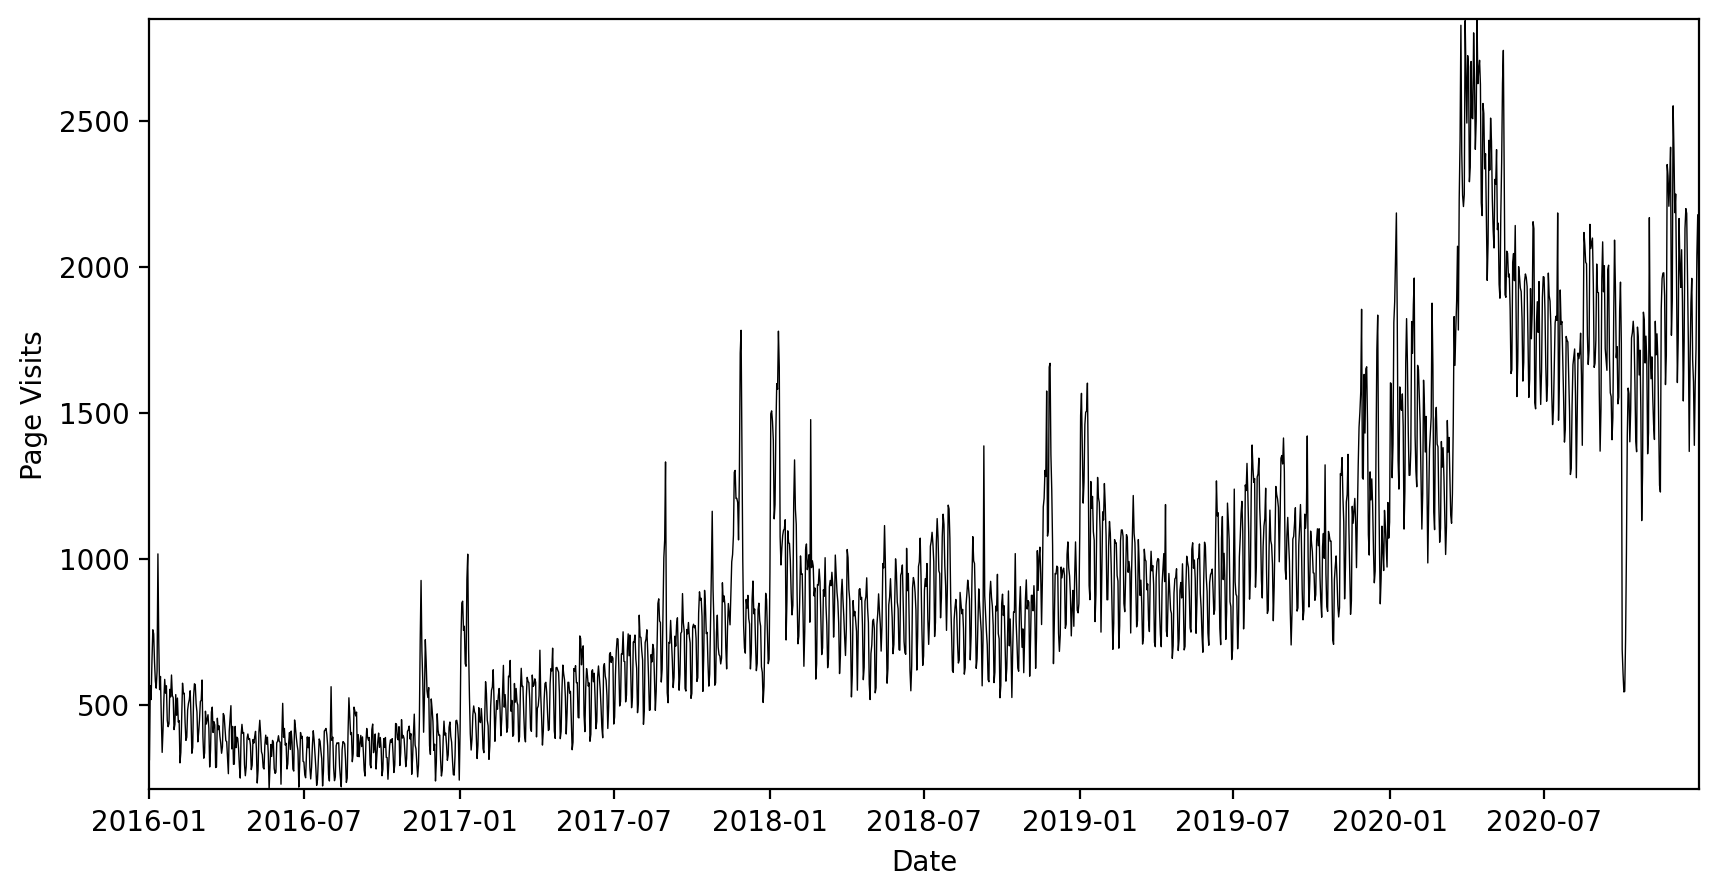

In [4]:
plt.rcParams["figure.figsize"] = (10,5)
plt.figure(dpi=dpi)
# extract only relevant columns: time and outcome variable
df = data[["Date","Visits"]]
df = df.rename(columns={'Date': 'x', 'Visits': 'y'})
# plot
x_range = [min(df['x']), max(df['x'])]
y_range = [min(df['y']), max(df['y'])]
plt.plot(df['x'], df['y'], color='black',linewidth=0.5,label='train_data')
ax = plt.gca()
ax.set_xlim(x_range)
ax.set_ylim(y_range)
#ax.set_title("Time Series of Page Visits")
ax.set_xlabel("Date")
ax.set_ylabel("Page Visits")
if save_fig:   
    plt.savefig("sim_plots/full_timeseries.png")
plt.show()

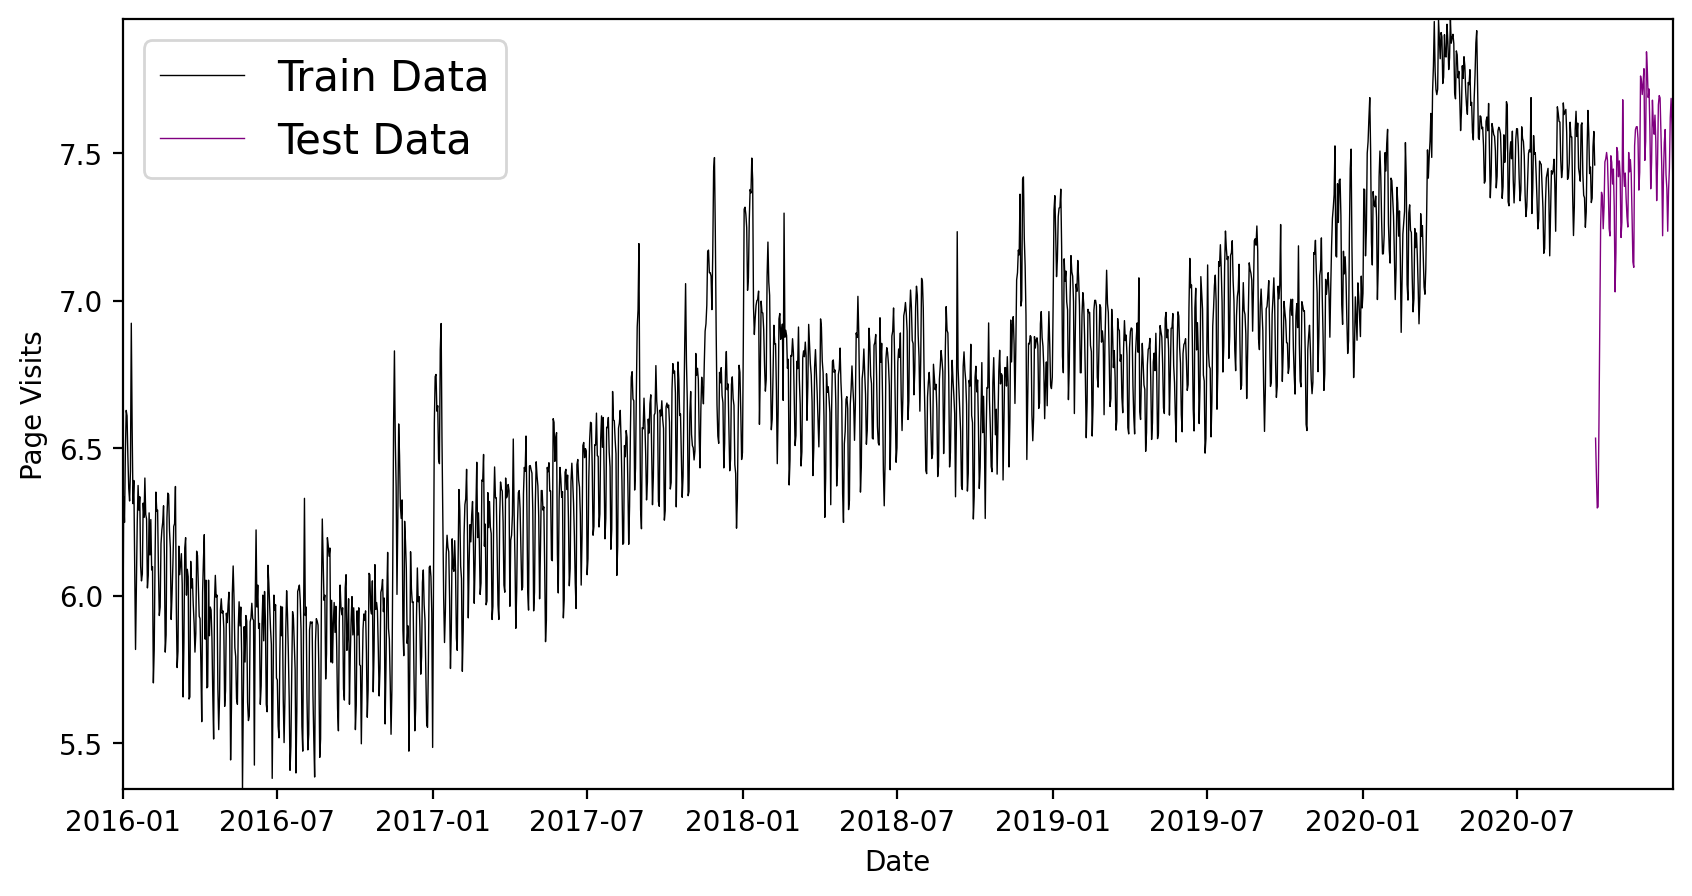

In [5]:
# DONT remove data by volatility, as the two stage method may perform even better than existing methods in such situations
plt.figure(dpi=dpi)
#df = df[df['x'] < '2019-08-01']
df['y'] = np.log(df['y'])
# Separate train, validation, test data
n = df.shape[0]
train_prop = 0.95
test_prop = 1 - train_prop
train_df = df[:int(n*train_prop)]
test_df = df[int(n*(1-test_prop)):]
# plot
x_range = [min(df['x']), max(df['x'])]
y_range = [min(df['y']), max(df['y'])]
plt.plot(train_df['x'], train_df['y'], color='black',linewidth=0.5,label='Train Data')
plt.plot(test_df['x'], test_df['y'], color='purple',linewidth=0.5,label='Test Data')
ax = plt.gca()
ax.set_xlim(x_range)
ax.set_ylim(y_range)
#ax.set_title("Time Series of Page Visits")
ax.set_xlabel("Date")
ax.set_ylabel("Page Visits")
ax.legend(fontsize = "15")
if save_fig:
    plt.savefig("sim_plots/clean_page_visits.png")
plt.show()

<Figure size 2000x1000 with 0 Axes>

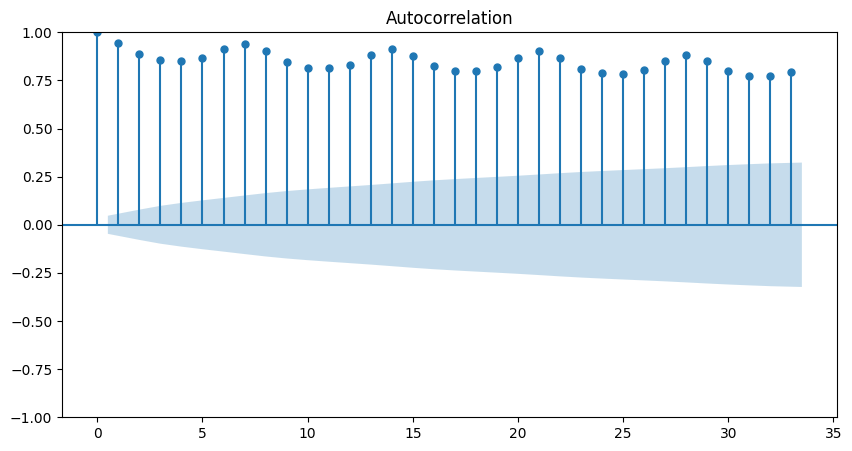

In [6]:
# Follow box jenkins methodology to fit a sarima model
# ONLY use TRAIN data
plt.rcParams["figure.figsize"] = (10,5)
plt.figure(dpi=dpi)
'''fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(train_df['y'], ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(train_df['y'], ax=axes[1])'''
sm.graphics.tsa.plot_acf(train_df['y'])
if save_fig:
    plt.savefig("sim_plots/autocorr.png")

<Figure size 2000x1000 with 0 Axes>

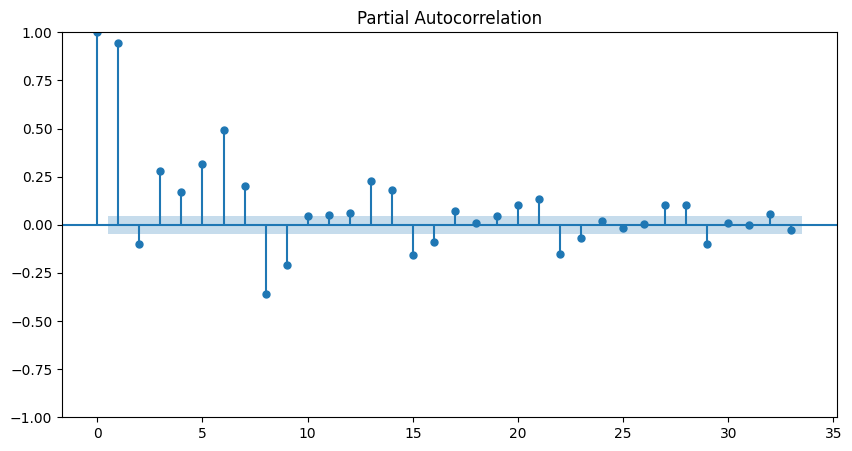

In [7]:
plt.figure(dpi=dpi)
'''fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(train_df['y'], ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(train_df['y'], ax=axes[1])'''
sm.graphics.tsa.plot_pacf(train_df['y'])
if save_fig:
    plt.savefig("sim_plots/p_autocorr.png")

In [8]:
# acf of differenced data
plt.figure(dpi=dpi)
model = sm.tsa.statespace.SARIMAX(train_df['y'], order = (0,0,0), seasonal_order = (0,1,0,7))
res = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.99386D-01    |proj g|=  2.22536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     16      1     0     0   1.847D-04  -2.994D-01
  F = -0.29938968475577760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

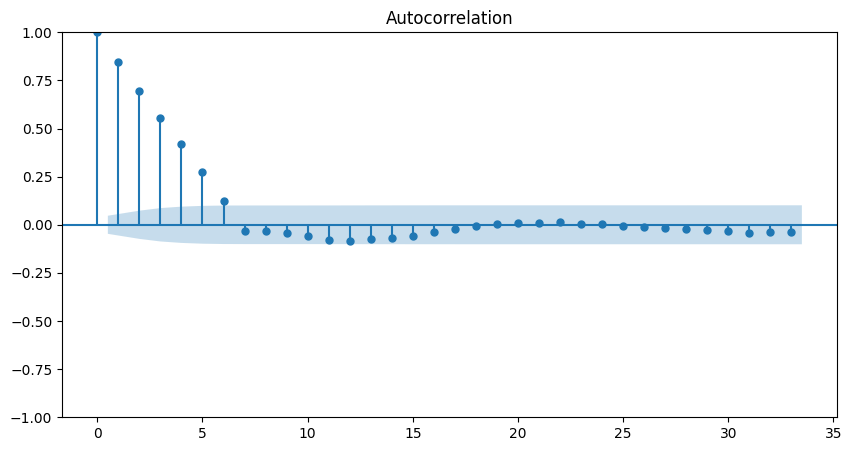

In [9]:
plt.figure(dpi=dpi)
sm.graphics.tsa.plot_acf(res.resid)
if save_fig:
    plt.savefig("sim_plots/autocorr_d.png")

<Figure size 2000x1000 with 0 Axes>

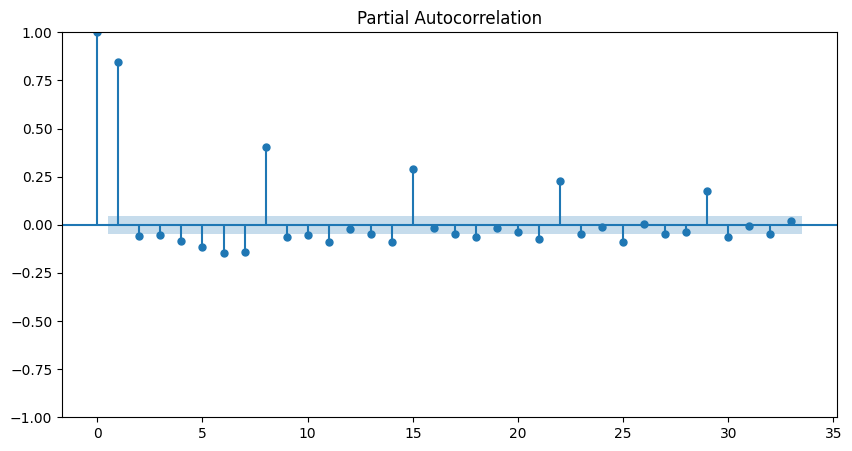

In [10]:
plt.figure(dpi=dpi)
sm.graphics.tsa.plot_pacf(res.resid)
if save_fig:
    plt.savefig("sim_plots/p_autocorr_d.png")

In [11]:
# dont bother with model fitting, just use the one from thesis
best_param1 = (0,1,6)
best_param2 = (1,0,1,7)

In [12]:
# fit the best model and check residuals
opt_model = sm.tsa.statespace.SARIMAX(train_df['y'], order = best_param1, seasonal_order = best_param2)
opt_res = opt_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10


 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.46124D-01    |proj g|=  3.40209D+00

At iterate    5    f= -7.88820D-01    |proj g|=  3.59093D-01

At iterate   10    f= -7.97173D-01    |proj g|=  9.30550D-02

At iterate   15    f= -7.99473D-01    |proj g|=  1.09063D-01

At iterate   20    f= -8.05427D-01    |proj g|=  1.51622D-01

At iterate   25    f= -8.10375D-01    |proj g|=  2.92730D-01

At iterate   30    f= -8.39486D-01    |proj g|=  1.35036D-01

At iterate   35    f= -8.48214D-01    |proj g|=  1.74861D-01

At iterate   40    f= -8.55553D-01    |proj g|=  1.08855D-02

At iterate   45    f= -8.56568D-01    |proj g|=  2.27573D-02

At iterate   50    f= -8.56679D-01    |proj g|=  5.06270D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


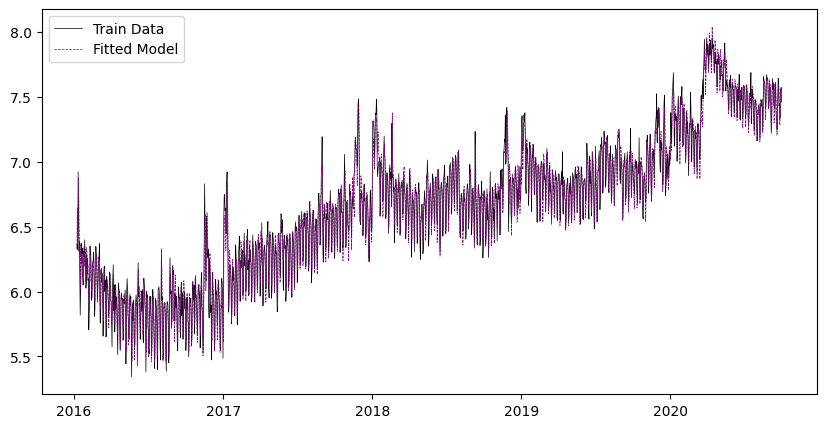

In [13]:
# sarimax uses kalman filter which uses the first period to find periodicity, hence fit is poor in the first 7 obs
# consider the fit and residuals after the first 7
#plt.figure(dpi=dpi)
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(train_df['x'][7:], train_df['y'][7:], color='black',linewidth=0.5,label='Train Data')
plt.plot(train_df['x'][7:], opt_res.fittedvalues[7:], color='purple',linewidth=0.5, ls='--',label='Fitted Model')
plt.legend()
if save_fig:
    plt.savefig("sim_plots/fitted_values.png")

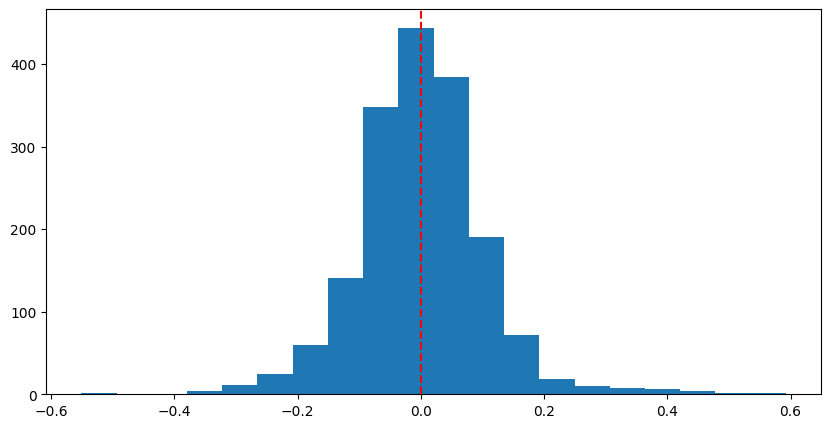

In [14]:
plt.rcParams["figure.figsize"] = (10,5)
plt.hist(opt_res.resid[7:], bins=20)
plt.axvline(x=0, color='red',ls='--')
if save_fig:    
    plt.savefig("sim_plots/resid_hist.png")

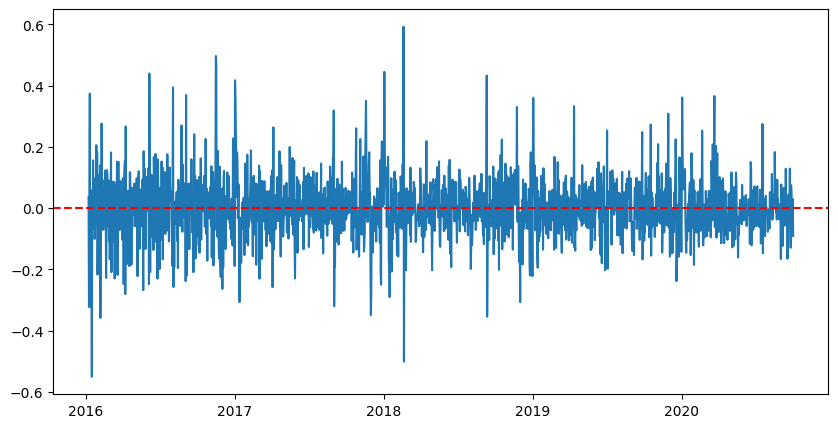

In [15]:
plt.plot(train_df['x'][7:], opt_res.resid[7:], label='residuals')
plt.axhline(y=0, color='red', ls='--')
if save_fig:    
    plt.savefig("sim_plots/resid.png")

NormaltestResult(statistic=np.float64(157.83295000090027), pvalue=np.float64(5.333476379357199e-35))

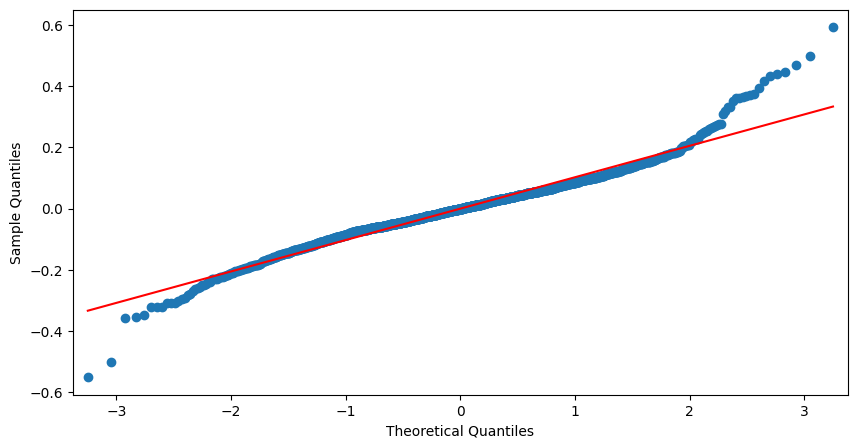

In [16]:
sm.qqplot(opt_res.resid[7:],line='s')
normaltest(opt_res.resid[7:])

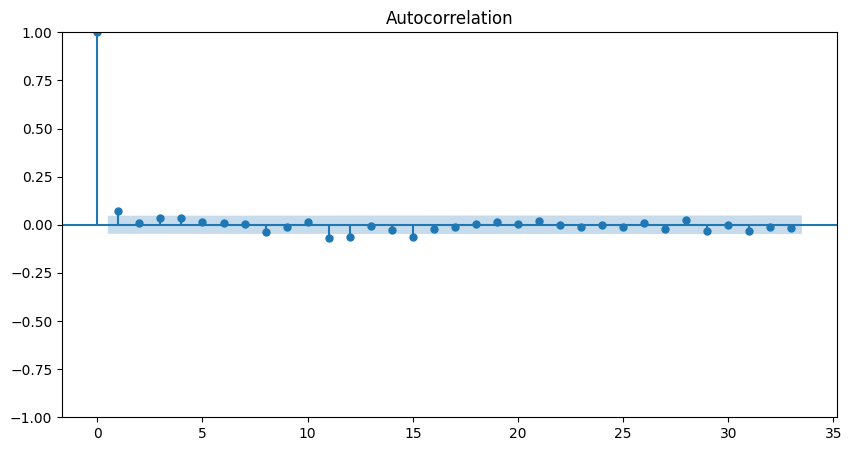

In [17]:
plt.rcParams["figure.figsize"] = (10,5)
sm.graphics.tsa.plot_acf(opt_res.resid)
if save_fig:
    plt.savefig("sim_plots/resid_acf.png")

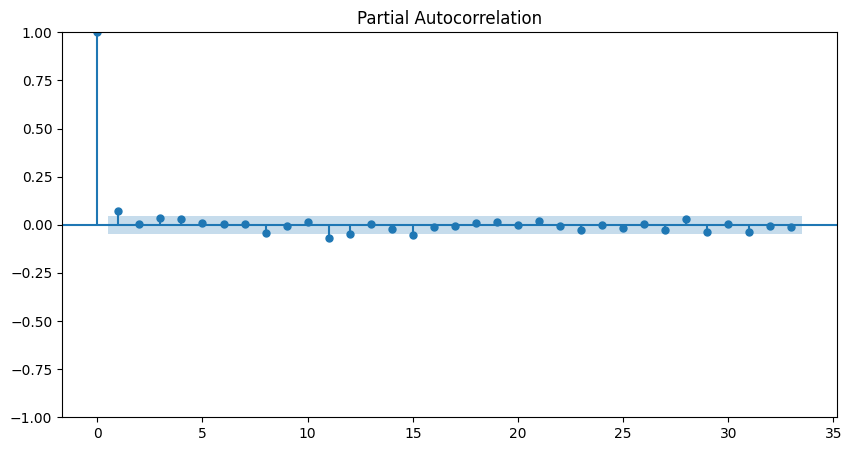

In [18]:
sm.graphics.tsa.plot_pacf(opt_res.resid)
if save_fig:
    plt.savefig("sim_plots/resid_pacf.png")

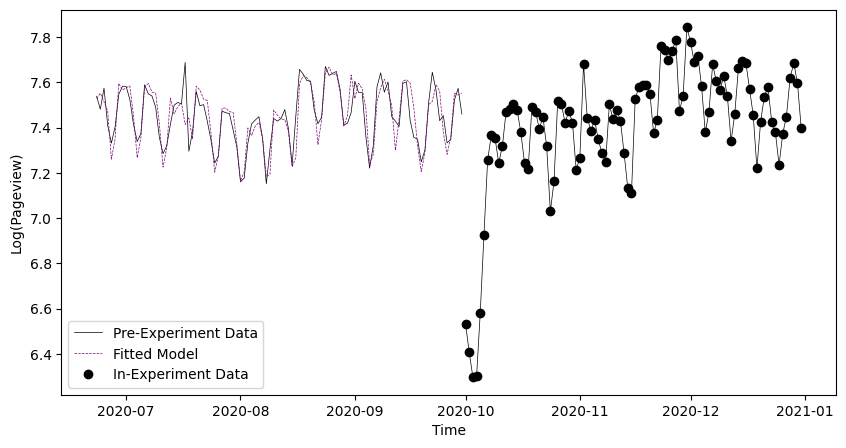

In [19]:
base_data = test_df.reset_index()
time_series_base(base_data, 
                 {'x_pre': train_df['x'][-100:], 
                 'y_pre': train_df['y'][-100:], 
                 'pre_fit': opt_res.fittedvalues[-100:]},
                 save_name = "sim_plots/raw_exp_data")

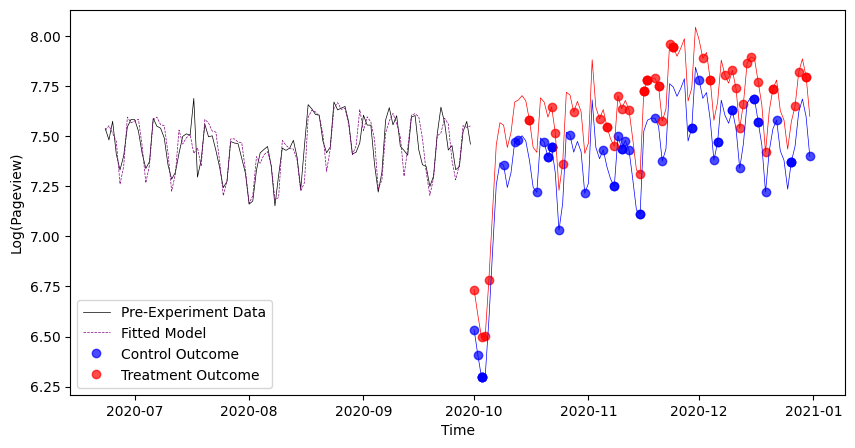

In [20]:
random.seed(1)
small_sample_size = 50
te = 0.2
exp_data = gen_exp_data(base_data['x'], base_data['y'], small_sample_size, te)
pre_exp_data = {'x_pre': train_df['x'][-100:], 
                'y_pre': train_df['y'][-100:], 
                'pre_fit': opt_res.fittedvalues[-100:]}
time_series_instance(exp_data, 
                     base_data,
                     pre_exp_data,
                     te,
                     save_name = "sim_plots/sample_exp_data")

# we switch the x values to integers for computation
x_num_range = np.arange(int(n*train_prop), n)
x_num_range = x_num_range - np.min(x_num_range)
control_x_num = x_num_range[exp_data['control_idx']]
treat_x_num = x_num_range[exp_data['treat_idx']]
# the numeric x values are necessary in counterfactual generation for regression, add them to exp_data
exp_data['control_x_num'] = control_x_num
exp_data['treat_x_num'] = treat_x_num
base_data['x_num_range'] = x_num_range

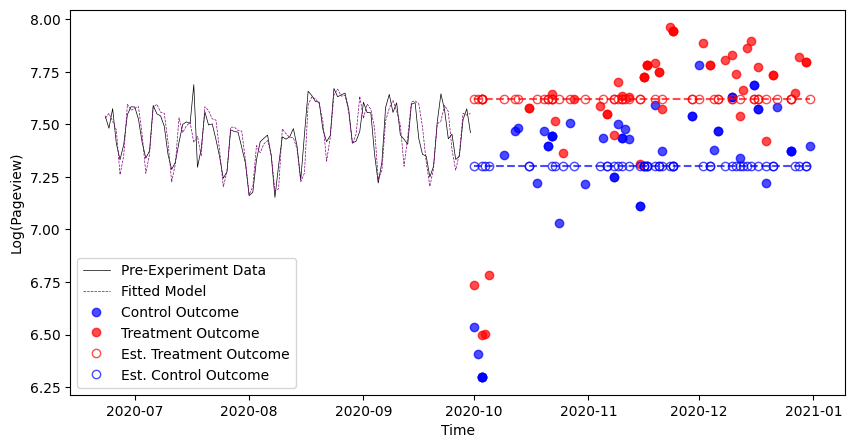

ATE:  0.31801890491876866 , SE:  0.07170937885671416


In [21]:
# Constant model
def const_mod(x):
    return np.zeros(len(x))
alpha_1 = np.mean(exp_data['treat_y'])
alpha_0 = np.mean(exp_data['control_y'])
model = {'alpha_1': alpha_1, 'alpha_0': alpha_0, 'mod': const_mod}
time_series_instance(exp_data,
                     base_data,
                     pre_exp_data,
                     te,
                     model = model,
                     save_name = "sim_plots/const_inst")

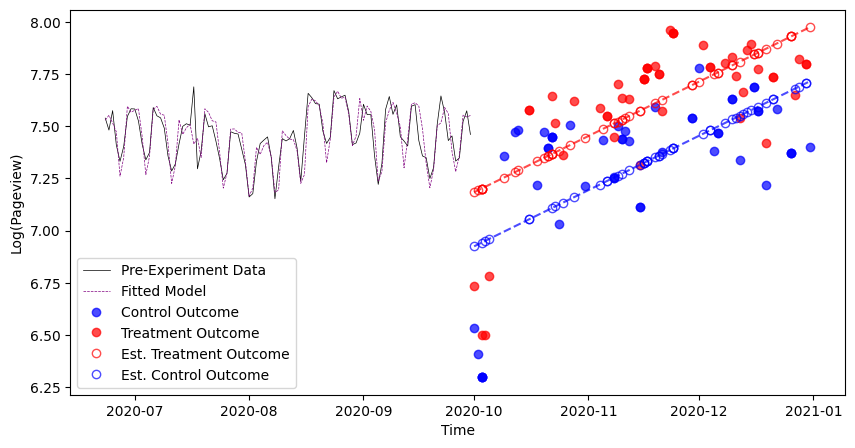

ATE:  0.2592730208800952 , SE:  0.055380775970143965


In [22]:
# Regression model

# compute regression coefficients 
treatxvar = np.var(treat_x_num,ddof=1)
controlxvar = np.var(control_x_num,ddof=1)
treatxcov = np.cov(treat_x_num, exp_data['treat_y'],ddof=1)[0,1]
controlxcov = np.cov(control_x_num, exp_data['control_y'],ddof=1)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha_1 = np.mean(exp_data['treat_y']) - np.mean(treat_x_num)*beta
alpha_0 = np.mean(exp_data['control_y']) - np.mean(control_x_num)*beta

# define model WITHOUT intercept
def regress_mod(x):
    return x*beta


# redefine model inputs for plotting
model = {'alpha_1': alpha_1, 'alpha_0': alpha_0, 'mod': regress_mod}
time_series_instance(exp_data,
                     base_data,
                     pre_exp_data,
                     te,
                     model = model,
                     save_name = "sim_plots/reg_inst")

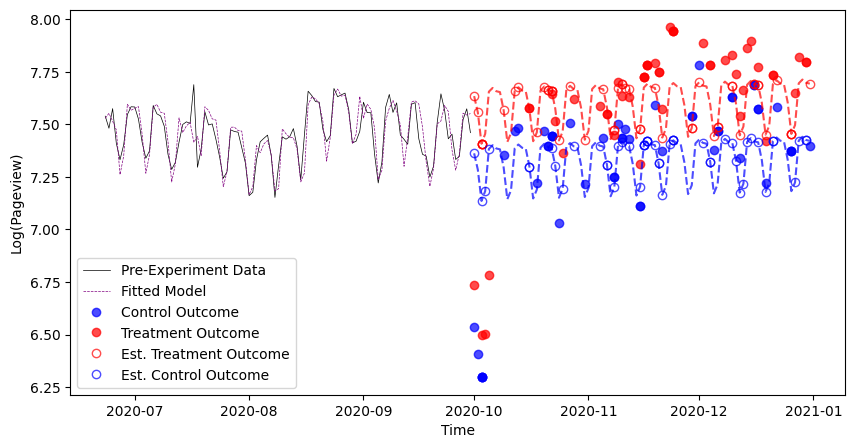

ATE:  0.27232248828298666 , SE:  0.062283963416503794


In [23]:
# ML model
# retrieve predictions of in-experiment outcomes from the SARIMA model
exp_preds = opt_res.predict(start=int(n*train_prop), end=n-1).to_numpy() 

# define ML model without intercept
def pre_exp_mod(x):
    # basically consider x as index
    return exp_preds[x]

# define intercepts
alpha_1 = np.mean(exp_data['treat_y'] - pre_exp_mod(exp_data['treat_idx']))
alpha_0 = np.mean(exp_data['control_y'] - pre_exp_mod(exp_data['control_idx']))

# redefine model inputs for plotting
model = {'alpha_1': alpha_1, 'alpha_0': alpha_0, 'mod': pre_exp_mod}

time_series_instance(exp_data,
                     base_data,
                     pre_exp_data,
                     te,
                     model = model,
                     save_name = "sim_plots/flex_inst")

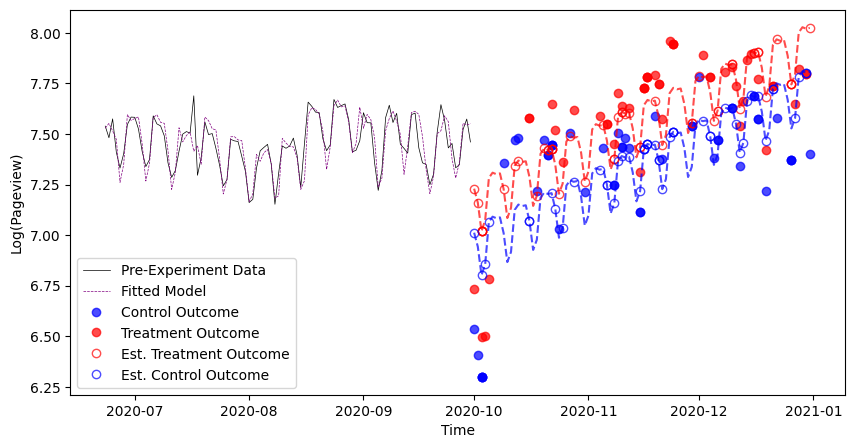

ATE:  0.21765272724892518 , SE:  0.04562976647555147


In [24]:
# Two stage model

# we work with the residual outcome in two stage model
treat_r = exp_data['treat_y'] - pre_exp_mod(exp_data['treat_idx'])
control_r = exp_data['control_y'] - pre_exp_mod(exp_data['control_idx'])

treatxcov = np.cov(exp_data['treat_idx'], treat_r, ddof=1)[0,1]
controlxcov = np.cov(exp_data['control_idx'], control_r, ddof=1)[0,1]
beta = (treatxcov + controlxcov)/(treatxvar + controlxvar)
alpha_1 = np.mean(treat_r) - np.mean(exp_data['treat_idx'])*beta
alpha_0 = np.mean(control_r) - np.mean(exp_data['control_idx'])*beta

def two_stage_mod(x):
    return x * beta + exp_preds[x]

# redefine model inputs for plotting
model = {'alpha_1': alpha_1, 'alpha_0': alpha_0, 'mod': two_stage_mod}

time_series_instance(exp_data,
                     base_data,
                     pre_exp_data,
                     te,
                     model = model,
                     save_name = "sim_plots/secondary_inst")



In [25]:
# set base data for simulation
base_data['x'] = x_num_range # no need for dates anymore, since we are only outputting ATE and SE

np.random.seed(1)
random.seed(1)
sim_num = 10000
sample_sizes = {1: 10, 2: 50, 3:100}
te = 0.2
res = gen_distribution(base_data, pre_exp_mod, sample_sizes, sim_num, te)

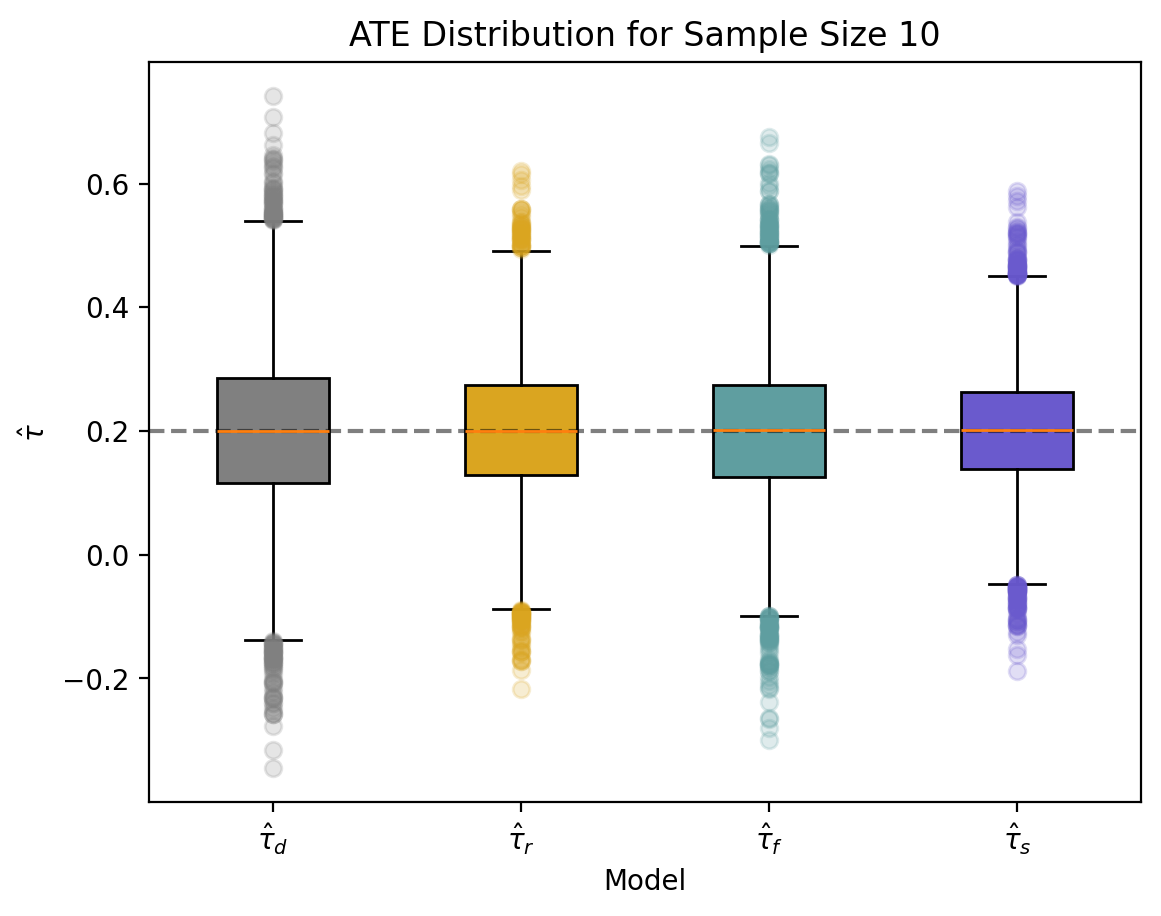

Sample size: 10 
ATE_d: 0.20 
ATE_r: 0.20 
ATE_ml: 0.20 
ATE_s: 0.20
Var_d: 0.017057102719234312 
Var_red_r: 29.88% 
Var_red_ml: 20.77% 
Var_red_s: 46.03%


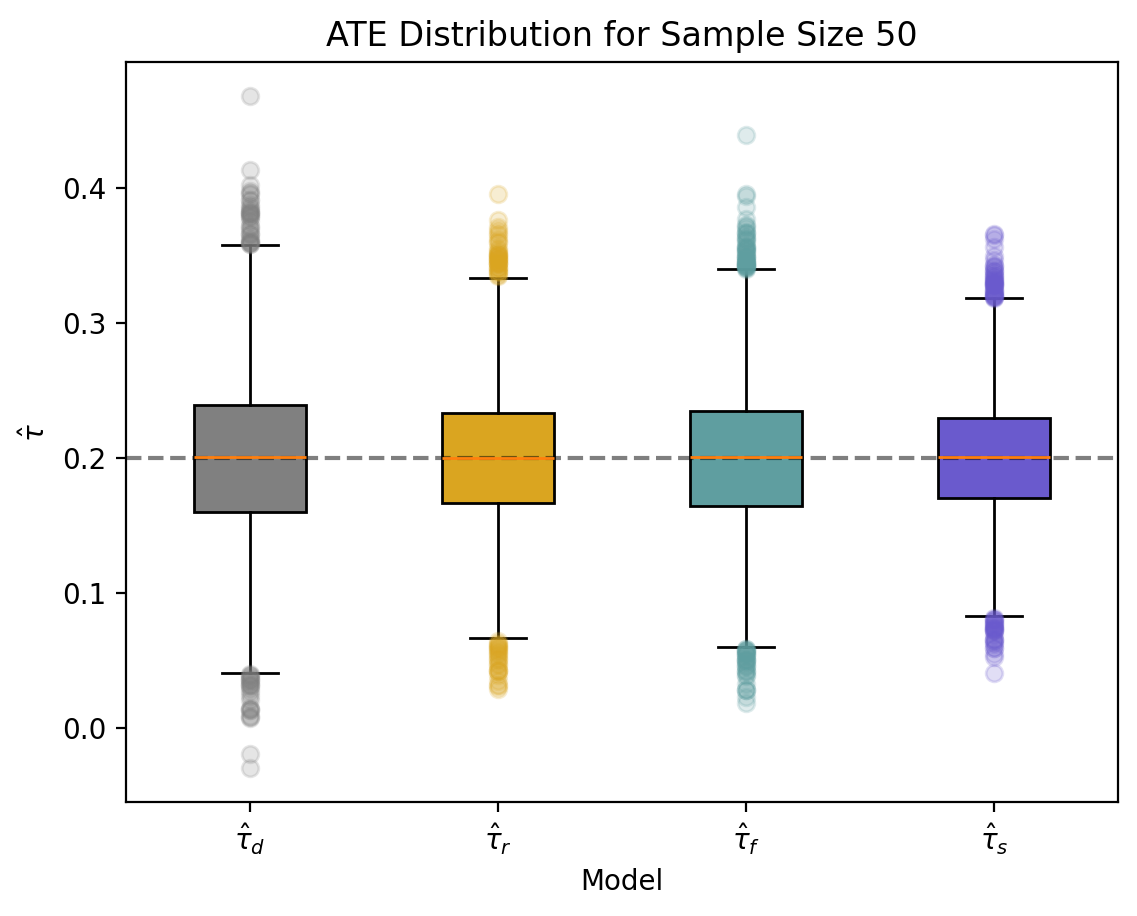

Sample size: 50 
ATE_d: 0.20 
ATE_r: 0.20 
ATE_ml: 0.20 
ATE_s: 0.20
Var_d: 0.0034253888936148858 
Var_red_r: 28.44% 
Var_red_ml: 20.93% 
Var_red_s: 43.81%


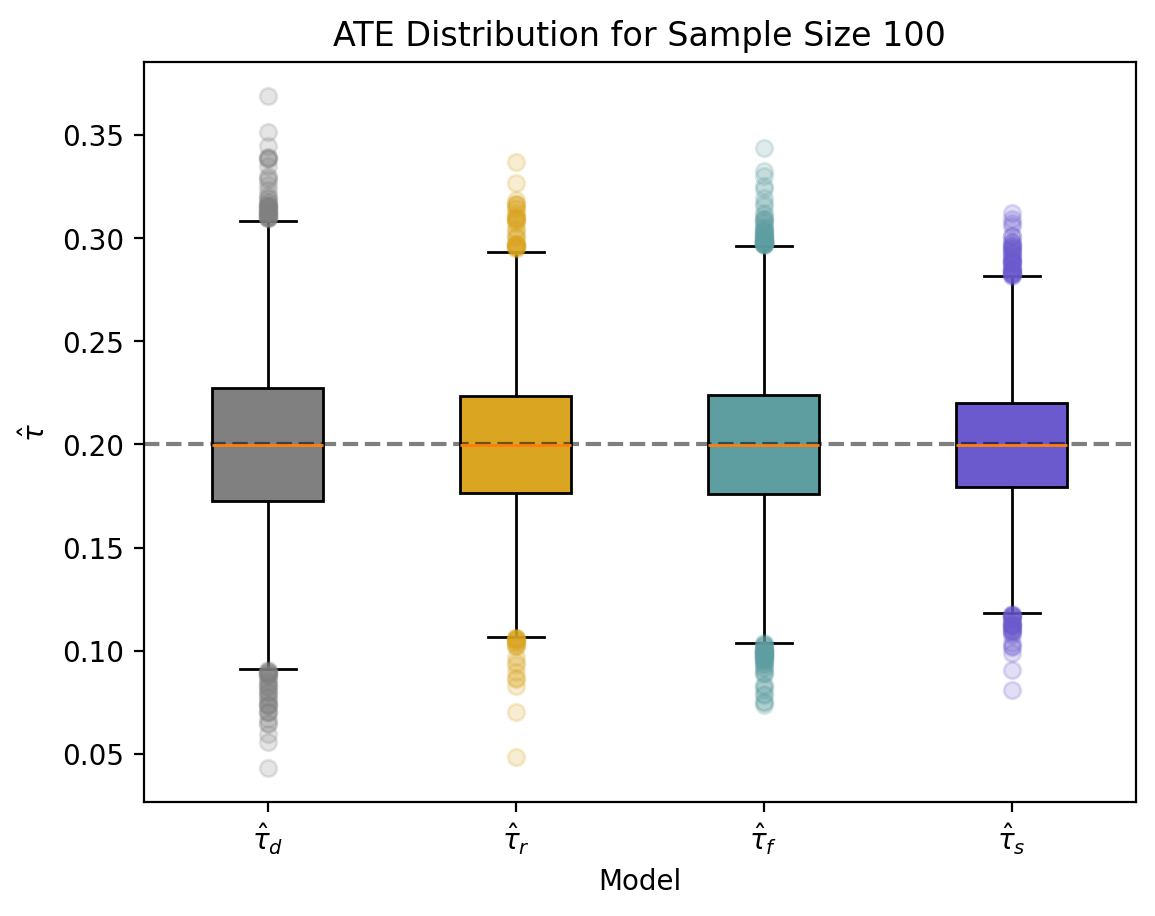

Sample size: 100 
ATE_d: 0.20 
ATE_r: 0.20 
ATE_ml: 0.20 
ATE_s: 0.20
Var_d: 0.001673933421295562 
Var_red_r: 28.45% 
Var_red_ml: 21.34% 
Var_red_s: 44.29%


In [26]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plot_ATE_boxplots(res, te, sample_sizes, save_name='sim_plots/sec_boxplot')

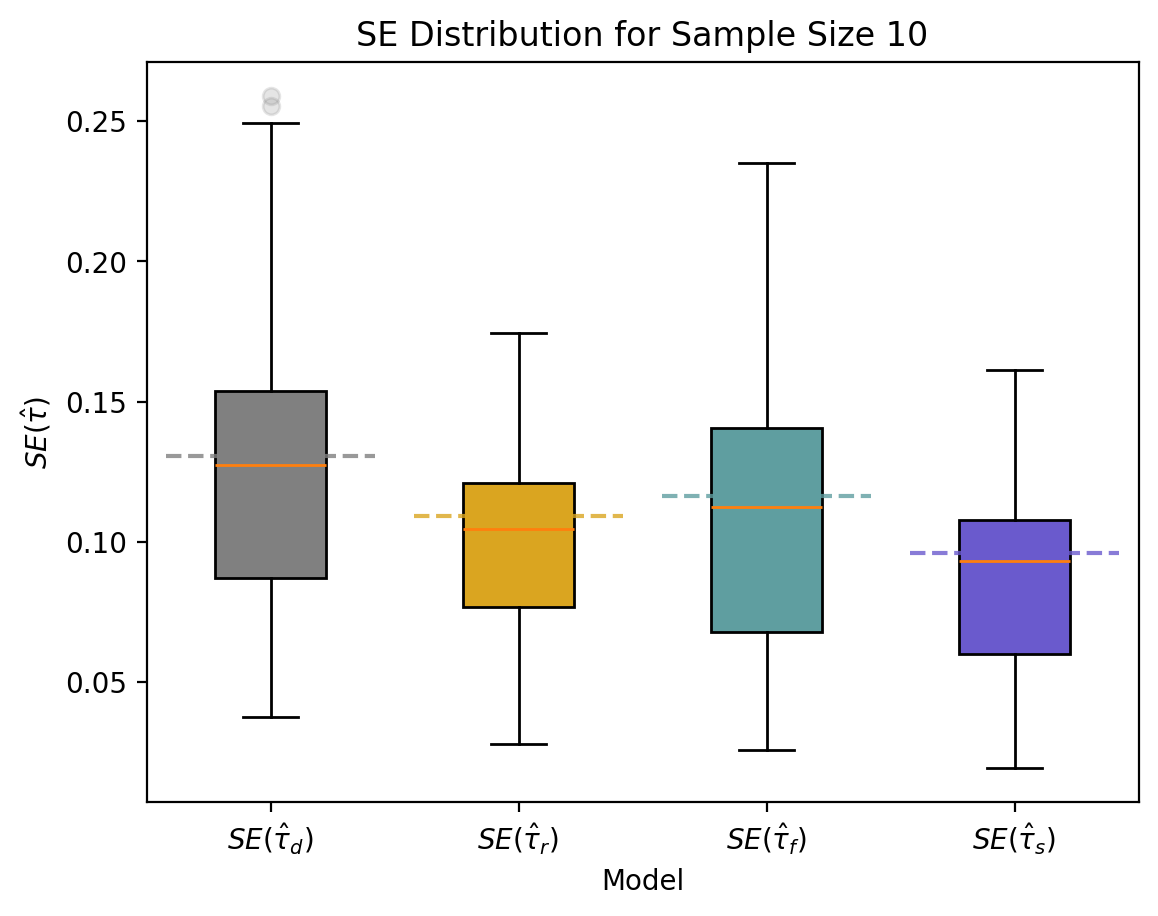

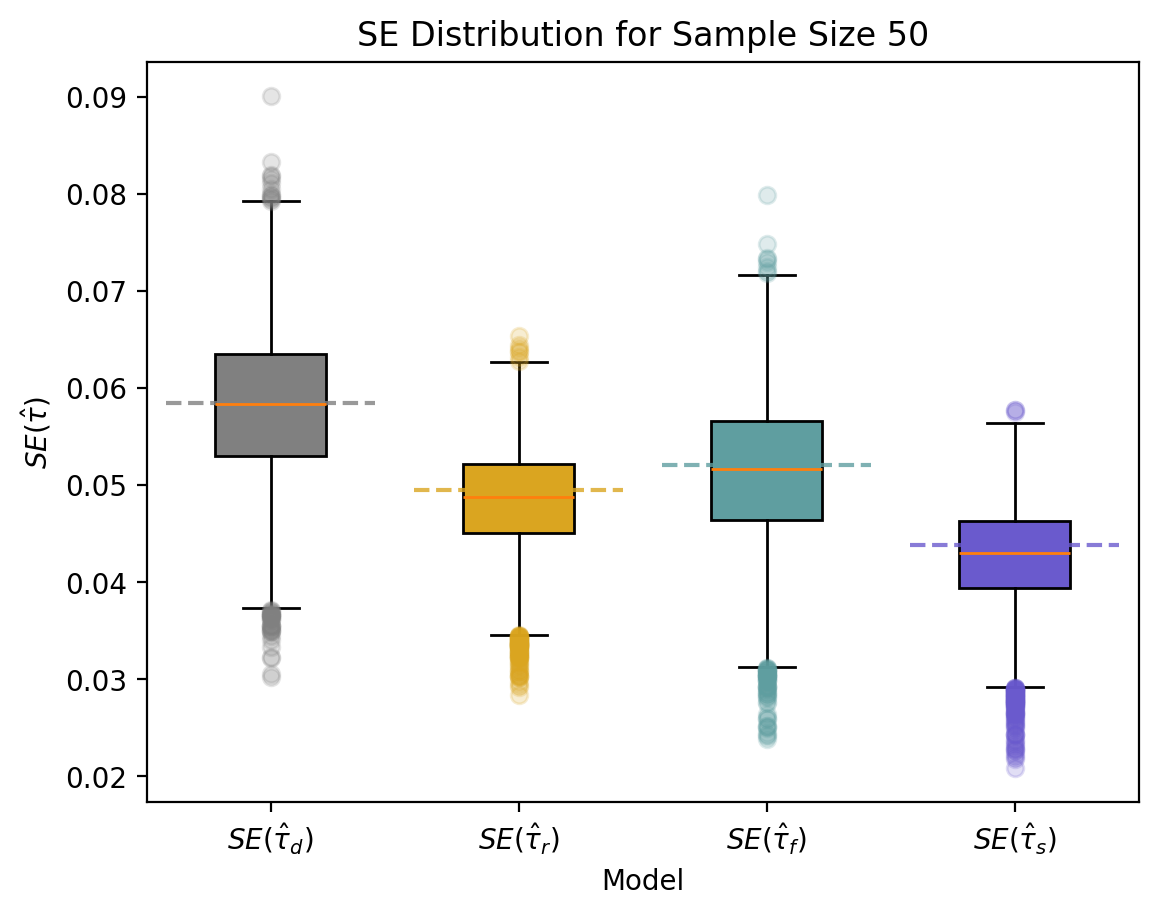

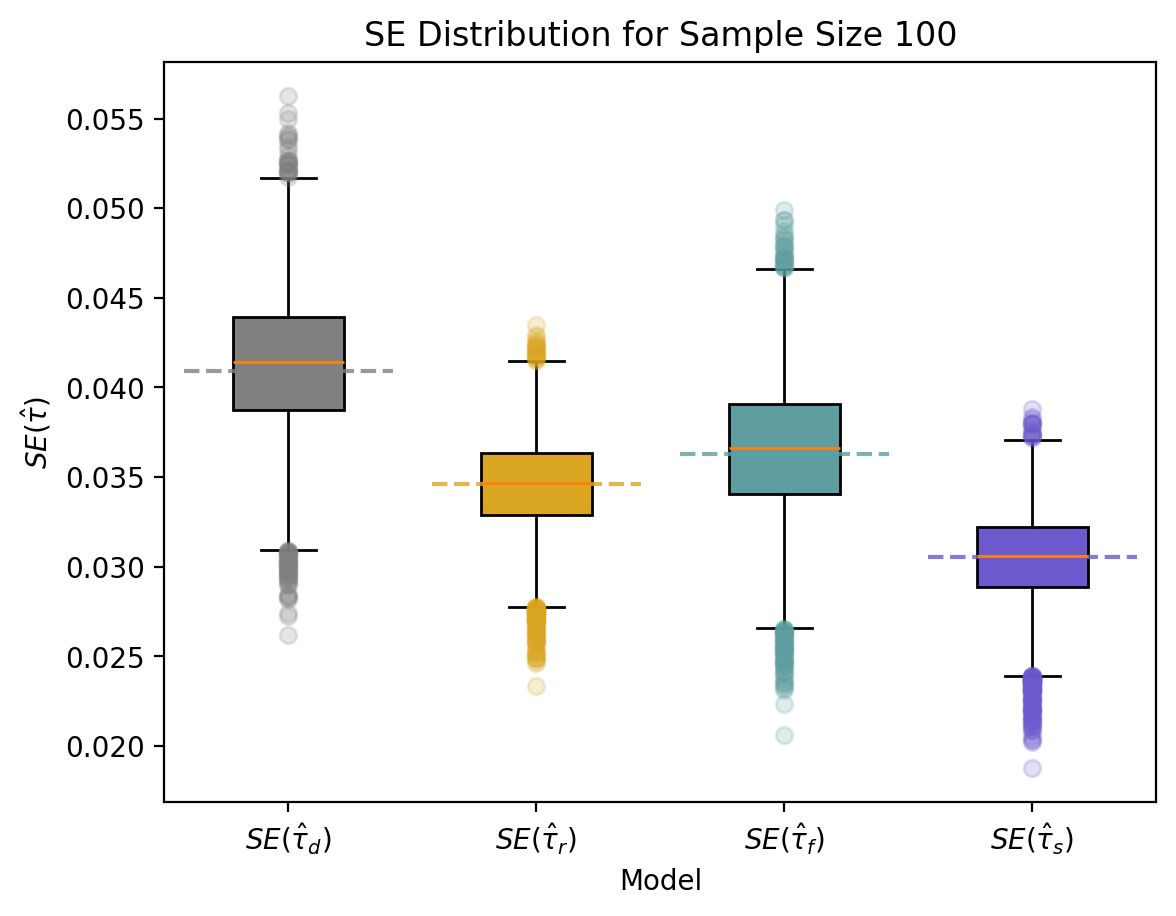

In [27]:
plot_SE_boxplots(res, sample_sizes, save_name='sim_plots/sec_boxplot')

In [29]:
# regenerate the exp_data example
random.seed(1)
base_data = test_df.reset_index()
exp_data = gen_exp_data(base_data['x'], base_data['y'], small_sample_size, te)
# we switch the x values to integers for computation
x_num_range = np.arange(int(n*train_prop), n)
x_num_range = x_num_range - np.min(x_num_range)
control_x_num = x_num_range[exp_data['control_idx']]
treat_x_num = x_num_range[exp_data['treat_idx']]
# the numeric x values are necessary in counterfactual generation for regression, add them to exp_data
exp_data['control_x_num'] = control_x_num
exp_data['treat_x_num'] = treat_x_num
base_data['x_num_range'] = x_num_range
treat_r = exp_data['treat_y'] - pre_exp_mod(exp_data['treat_idx'])
control_r = exp_data['control_y'] - pre_exp_mod(exp_data['control_idx'])

# testing out quadratic adjustment
# construct X matrix
import statsmodels.api as sm
x_s = np.concatenate((treat_x_num, control_x_num))
treat_indicator = np.concatenate((np.ones(small_sample_size),np.zeros(small_sample_size)))
X_mat = np.column_stack((np.ones(2*small_sample_size), treat_indicator, x_s, x_s**2, x_s**3, x_s**4))
y_vec = np.concatenate((treat_r, control_r))
model = sm.OLS(y_vec, X_mat)
results = model.fit()
params = results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     147.3
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           7.07e-43
Time:                        12:49:05   Log-Likelihood:                 75.261
No. Observations:                 100   AIC:                            -138.5
Df Residuals:                      94   BIC:                            -122.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0553      0.046    -23.164      0.0

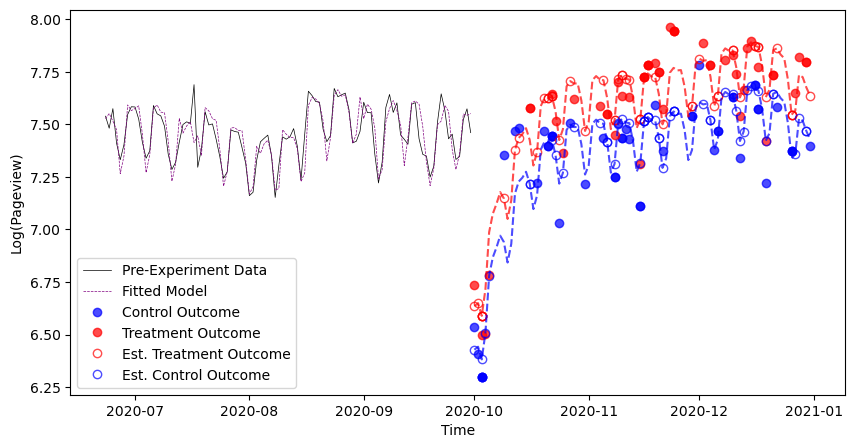

ATE:  0.20732708033112904 , SE:  0.02303156095725224


In [30]:
# plot the instance of exp_data and their counterfactuals with secondary quartic adjustment 

plt.rcParams["figure.figsize"] = (10,5)
# define the mod without intercept
def quartic_mod(x):
    return  pre_exp_mod(x) + params[0] + x * params[2] + x**2 * params[3] + x**3 * params[4] + x**4 * params[5]

alpha_1 = np.mean(exp_data['treat_y'] - quartic_mod(treat_x_num))
alpha_0 = np.mean(exp_data['control_y'] - quartic_mod(control_x_num))

# redefine model inputs for plotting
model = {'alpha_1': alpha_1, 'alpha_0': alpha_0, 'mod': quartic_mod}

time_series_instance(exp_data,
                     base_data,
                     pre_exp_data,
                     te, 
                     save_name = "sim_plots/quad_inst",
                     model = model)


In [31]:
np.random.seed(1)
random.seed(1)
base_data['x'] = x_num_range # change base_data x values to integers from dates for easier processing

sim_num = 10000
sample_sizes = {1: 10, 2: 50, 3:100}
te = 0.2

res = gen_distribution_q(base_data,
                         pre_exp_mod, 
                         sample_sizes, 
                         sim_num, 
                         te)

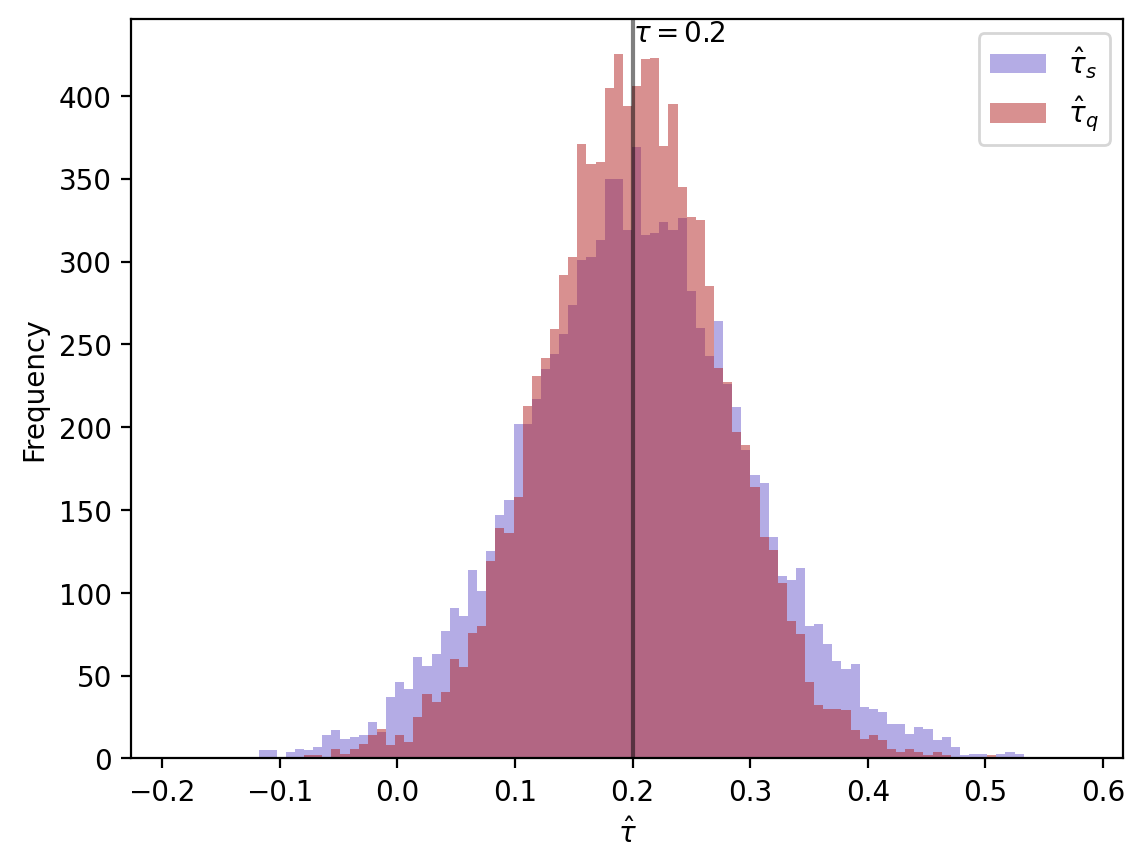

Sample size: 10


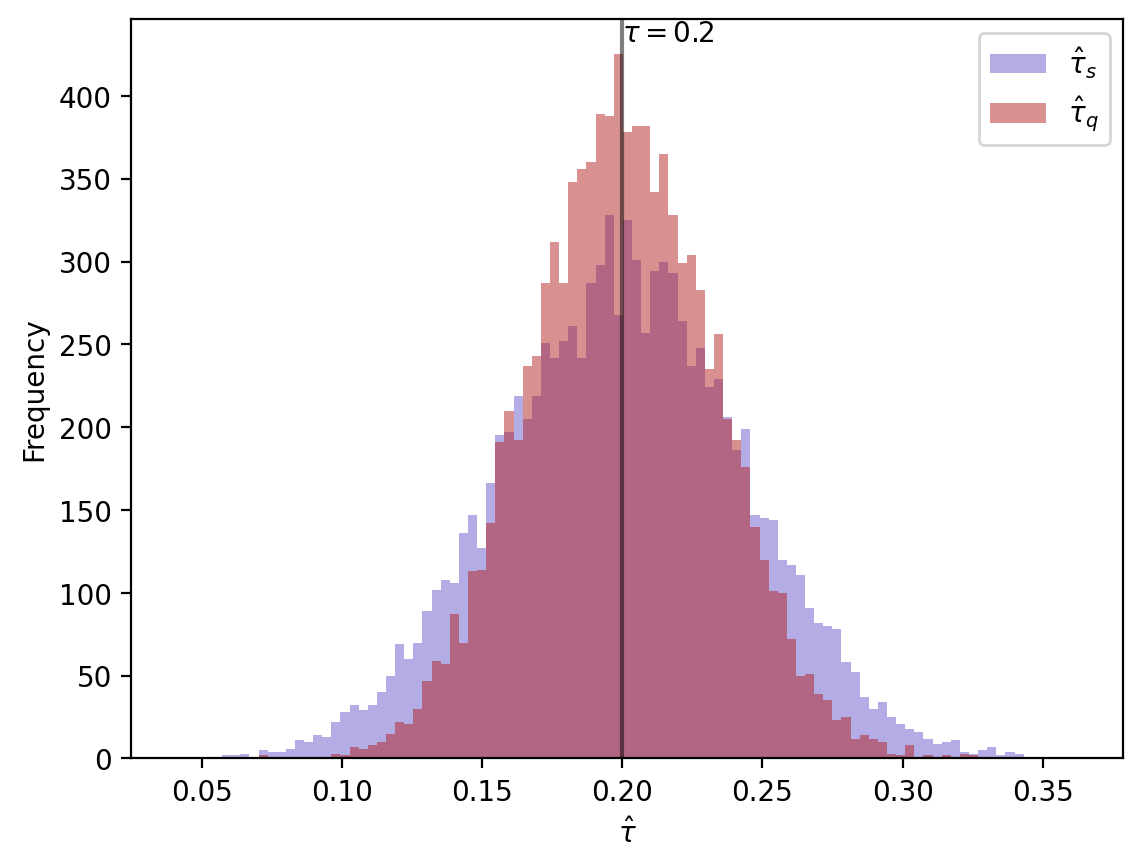

Sample size: 50


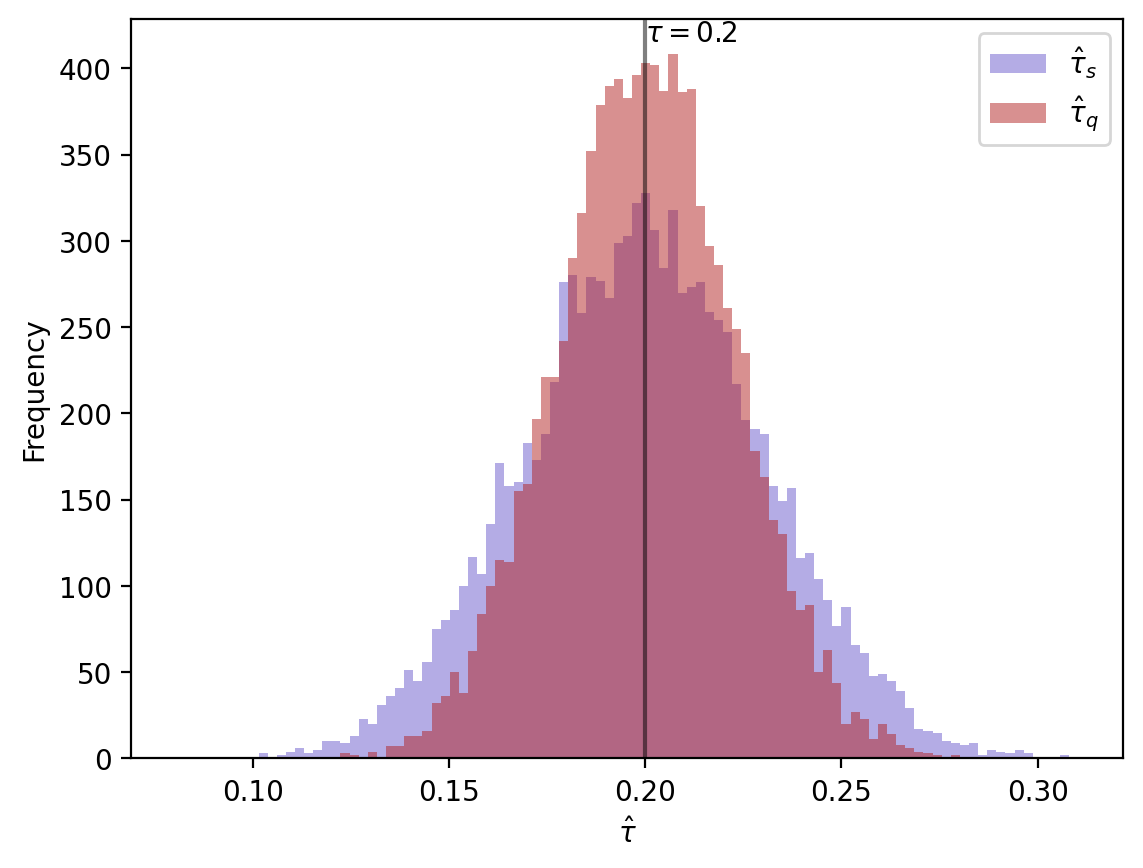

Sample size: 100


In [32]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plot_ATE_distribution_q(res, te, sample_sizes, save_name="sim_plots/quad")

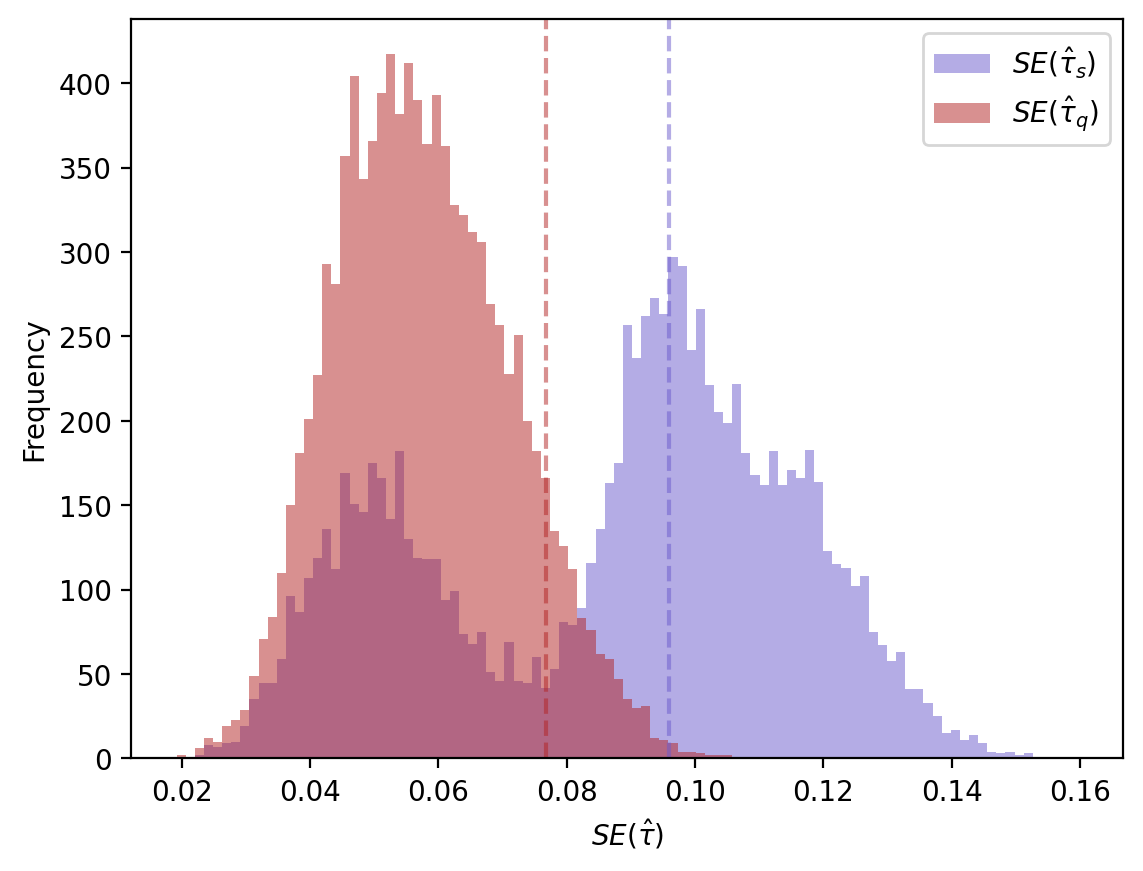

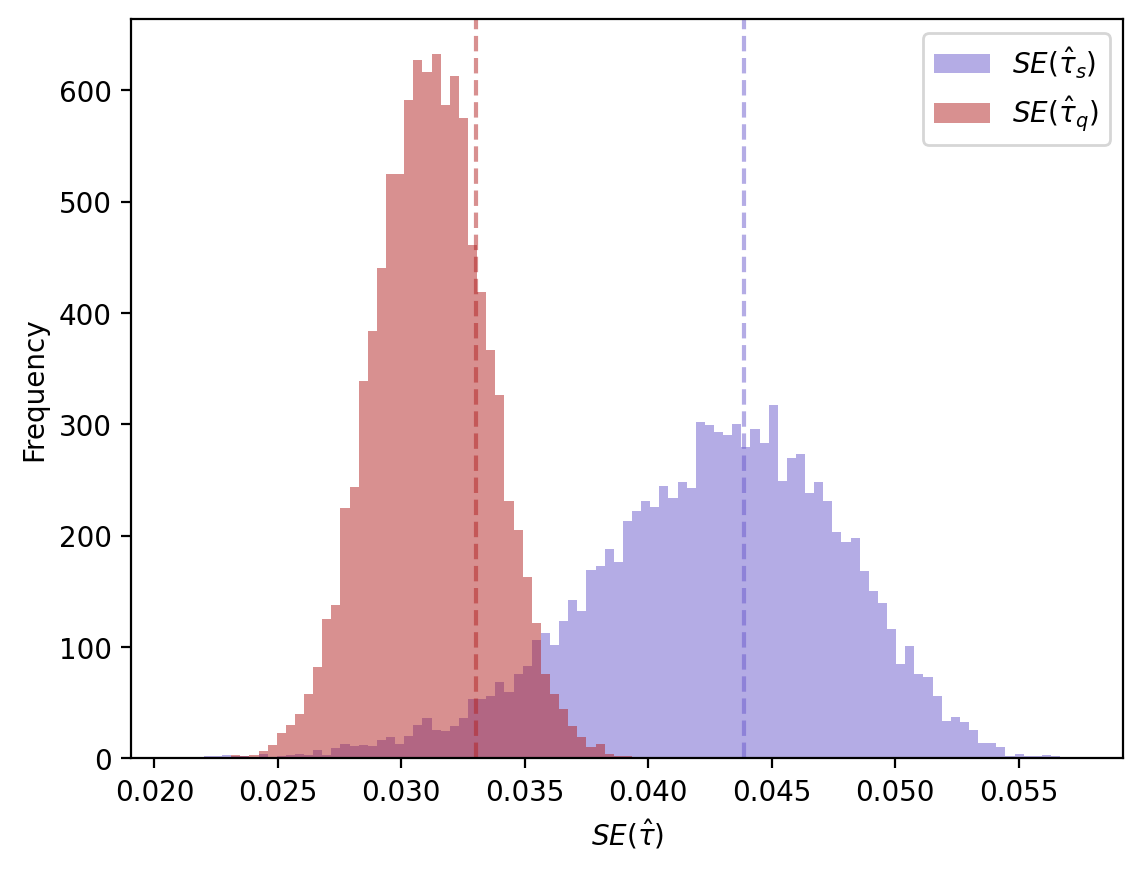

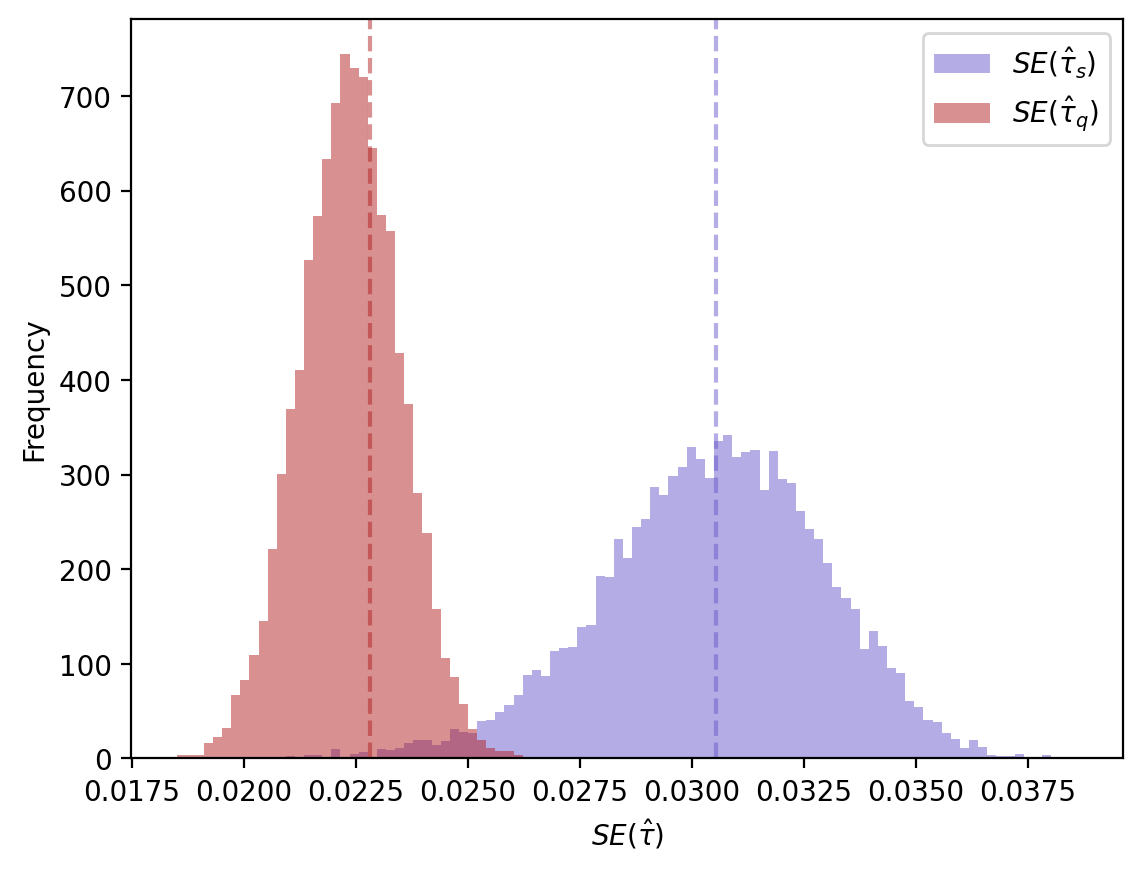

In [33]:
plot_SE_distribution_q(res, save_name="sim_plots/quad")

In [34]:
np.random.seed(1)
random.seed(1)
effect_size = [0, 0.1, 0.2, 0.3]
big_res = {}
for te in effect_size:
    if te == 0.2:
        big_res[te] = res # reuse above result for te = 0.2
    else:
        big_res[te] = gen_distribution_q(base_data,
                                        pre_exp_mod, 
                                        sample_sizes, 
                                        sim_num, 
                                        te)

In [35]:
# for 0 effect, any test statistic with absolute value > 1.96
# for non zero effect, any test statistic with aboslute value > 1.96 is a success
from scipy.stats import t
positive_counts = {}
for ss in sample_sizes:
    positive_counts[ss] = pd.DataFrame(columns = ['two_t','reg_t','ml_t','s_t','q_t'], index = effect_size)
    t_quantile = t.ppf(0.975, 2*sample_sizes[ss]-2)
    for te in effect_size:
        test_stats = pd.DataFrame(columns = ['two_t','reg_t','ml_t','s_t','q_t'])
        atese = big_res[te][ss]
        test_stats['two_t'] = atese['two_est'] / atese['two_se']
        test_stats['reg_t'] = atese['reg_est'] / atese['reg_se']
        test_stats['ml_t'] = atese['ml_est'] / atese['ml_se']
        test_stats['s_t'] = atese['s_est'] / atese['s_se']
        test_stats['q_t'] = atese['q_est'] / atese['q_se']
        positive_counts[ss].loc[te] = (abs(test_stats) > t_quantile).sum(axis=0)
positive_counts

{1:     two_t reg_t  ml_t   s_t   q_t
 0.0   420   564   348   531  1259
 0.1  1390  1870  1970  2612  4127
 0.2  4064  5018  5013  5935  8384
 0.3  6282  7620  6803  8290  9815,
 2:     two_t reg_t  ml_t    s_t    q_t
 0.0   475   548   476    533    615
 0.1  4131  5409  4989   6458   8751
 0.2  9157  9788  9605   9948  10000
 0.3  9978  9999  9996  10000  10000,
 3:      two_t  reg_t   ml_t    s_t    q_t
 0.0    458    502    463    494    544
 0.1   6741   8194   7750   9005   9926
 0.2   9975   9998   9995  10000  10000
 0.3  10000  10000  10000  10000  10000}